<a href="https://colab.research.google.com/github/wmaciek/App_inz/blob/master/2_PneumoniaMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install medmnist

In [ ]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
import torchvision.transforms as transforms
import torch.nn.functional as F
import seaborn as sn
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


import medmnist
from medmnist import INFO, Evaluator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This is 2. notebook for PneumoniaMNIST Dataset (1 canal)<br>
2 clases <br>train: 4708<br>val: 524<br>test: 624

In [ ]:
#selecting device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.1.0 @ https://github.com/MedMNIST/MedMNIST/


#Loading dataset

In [ ]:
data_flag = 'pneumoniamnist'

download = True

NUM_EPOCHS = 30
BATCH_SIZE = 90

lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [ ]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5],)
    ])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
val_dataset = DataClass(split='val', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

  0%|          | 0/4170669 [00:00<?, ?it/s]

Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz


In [ ]:
#Creating sampler

class_weights = np.array([40, 6])
sample_weights = np.array([0] * len(train_dataset))

for i, (data,label) in enumerate(train_dataset):
  class_weight = class_weights[label]
  sample_weights[i] = class_weight

sample_weights = torch.from_numpy(sample_weights)
sampler = WeightedRandomSampler(sample_weights.type('torch.DoubleTensor'), len(sample_weights), replacement=True)

In [ ]:
# encapsulate data into dataloader form
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)
train2_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE)

#Info + samples

In [ ]:
info

{'python_class': 'PneumoniaMNIST',
 'description': 'The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.',
 'url': 'https://zenodo.org/record/6496656/files/pneumoniamnist.npz?download=1',
 'MD5': '28209eda62fecd6e6a2d98b1501bb15f',
 'task': 'binary-class',
 'label': {'0': 'normal', '1': 'pneumonia'},
 'n_channels': 1,
 'n_samples': {'train': 4708, 'val': 524, 'test': 624},
 'license': 'CC BY 4.0'}

In [ ]:
label_array_train = []
for (data, labels) in train_dataset:
  label_array_train.append(labels)
index_values = np.arange(1, len(label_array_train)+1)
column_values = ['class']
  
# creating the train dataframe
df_train = pd.DataFrame(data = label_array_train, 
                  index = index_values, 
                  columns = column_values)

label_array_val = []
for (data, labels) in val_dataset:
  label_array_val.append(labels)
index_values = np.arange(1, len(label_array_val)+1)
column_values = ['class']
  
# creating the val dataframe
df_val = pd.DataFrame(data = label_array_val, 
                  index = index_values, 
                  columns = column_values)

label_array_test = []
for (data, labels) in test_dataset:
  label_array_test.append(labels)
index_values = np.arange(1, len(label_array_test)+1)
column_values = ['class']
  
# creating the test dataframe
df_test = pd.DataFrame(data = label_array_test, 
                  index = index_values, 
                  columns = column_values)

In [ ]:
train_size_arange = np.arange(1, len(label_array_train)+1)
train_1 = sum(df_train["class"]==1)
train_0 = sum(df_train["class"]==0)

val_size_arange = np.arange(1, len(label_array_val)+1)
val_1 = sum(df_val["class"]==1)
val_0 = sum(df_val["class"]==0)

test_size_arange = np.arange(1, len(label_array_test)+1)
test_1 = sum(df_test["class"]==1)
test_0 = sum(df_test["class"]==0)

In [ ]:
import plotly.graph_objects as go
sets=['Zbiór Testowy', 'Zbiór Sprawdzający', 'Zbiór Testujący']
fig = go.Figure(data=[
    go.Bar(name='Zapalenie płuc', x=sets, y=[train_1, val_1, test_1]),
    go.Bar(name='Zdrowe płuca', x=sets, y=[train_0, val_0, test_0])]
    )
fig.update_layout(title="Ilość próbek w zbiorach", width=600, height=300,
                  margin=dict(l=00, r=20, b=30, t=40, pad=10),
                  legend=dict(yanchor="top",xanchor="right"))

fig.update_yaxes(title_text='Ilość')
fig.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning:

The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

100%|██████████| 4708/4708 [00:00<00:00, 5120.55it/s]


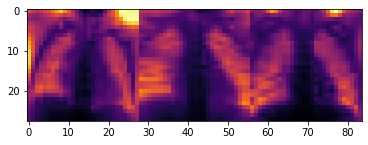

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
tr_l = np.array(train_dataset)
tr_l.shape
data_frame = pd.DataFrame()
img = []
for inputs, targets in tqdm(train_dataset):
  img.append(inputs)
  
sample_pics = [img]
pic1 = img[0].reshape(28,-1)
pic2 = img[1].reshape(28,-1)
pic3 = img[2].reshape(28,-1)
plt.imshow(np.hstack((pic1,pic2, pic3)), cmap="inferno_r")

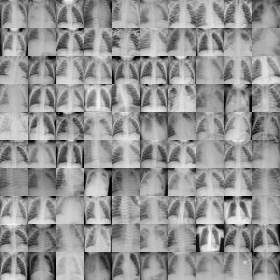

In [ ]:
#or using montage
train_dataset.montage(length=10)

**1) Real chest X-ray**

<img src="https://drive.google.com/uc?export=view&id=1ZIm52DdHTEH9sTe1iSfv-yN9ih8Kk95Z" width=450></img>


# CNN model

In [ ]:
# model class for pneumonia prediction
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 20, 3, 1)
        self.conv1_bn = nn.BatchNorm2d(20)

        self.conv2 = nn.Conv2d(20, 40, 3, 1)
        self.conv2_bn = nn.BatchNorm2d(40)

        self.conv3 = nn.Conv2d(40, 80, 3, 1)
        self.conv3_bn = nn.BatchNorm2d(80)

        self.conv4 = nn.Conv2d(80, 160, 3, 1)
        self.conv4_bn = nn.BatchNorm2d(160)

        self.fc1 = nn.Linear(7*7*160, 1000) #((((28-2)/2)-2)/2) = 5,..
        self.fc1_bn = nn.BatchNorm1d(1000)

        self.fc2 = nn.Linear(1000, 500)
        self.fc2_bn = nn.BatchNorm1d(500)

        self.fc3 = nn.Linear(500, 50)
        self.fc3_bn = nn.BatchNorm1d(50)

        self.fc4 = nn.Linear(50, 2)

    def forward(self, X):
        X = self.conv1(X)
        X = F.relu(self.conv1_bn(X))  #1

        X = F.max_pool2d(X, 2, 2)

        X = self.conv2(X)
        X = F.relu(self.conv2_bn(X))

        X = self.conv3(X)
        X = F.relu(self.conv3_bn(X))  #3

        X = self.conv4(X)
        X = F.relu(self.conv4_bn(X))  #4

        X = X.view(-1, 7*7*160)

        X = self.fc1(X)
        X = F.relu(self.fc1_bn(X))
        X = self.fc2(X)
        X = F.relu(self.fc2_bn(X))
        X = self.fc3(X)
        X = F.relu(self.fc3_bn(X))
        X = self.fc4(X)
        return F.softmax(X, dim=1)

In [ ]:
model = ConvolutionalNetwork().to(device)
loss_function = nn.BCELoss()#weight=torch.tensor([0.3,0.7])) #for binary class.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv1_bn): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1))
  (conv2_bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1))
  (conv3_bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(80, 160, kernel_size=(3, 3), stride=(1, 1))
  (conv4_bn): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=7840, out_features=1000, bias=True)
  (fc1_bn): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1000, out_features=500, bias=True)
  (fc2_bn): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=500, out_featur

#Training

In [ ]:
def get_accuracy(model, test_loader):
  correct = 0
  total = 0
  with torch.no_grad():
      for (data, labels) in test_loader:
          net_out = model(data) 
          predicted_labels = []
          for row in net_out:
            predicted_labels.append(torch.argmax(row))

          for i, object in enumerate(predicted_labels):
              if predicted_labels[i] == labels[i]:
                correct += 1
              total += 1
  return correct/total

In [ ]:
from tqdm.notebook import tqdm

min_valid_loss = np.inf
best_both = 0
best_precission = 0
MODELPATHAGE = "/content/drive/MyDrive/Colab Notebooks/Med_MNIST_inż/model_pneumonia.pth"

historical_train_loss = []
historical_validation_loss = []
epochs = []
i = 0
best_acc = 0

for epoch in range(NUM_EPOCHS):
  
  train_loss = 0.0

#  TRAINING
  for (data, labels) in tqdm(train_loader):
    labels_1hot_t = []
    optimizer.zero_grad()  #cleaning previous gradients
    target = model(data)  #foreward pass
    for l in labels:
      labels_1hot_t.append(np.eye(2)[l])
    loss = loss_function(target, torch.Tensor(labels_1hot_t))
    loss.backward()  #backward pass
    optimizer.step()  #updating weights
    train_loss += loss.item()
    histloss = loss
    i+=1

#  VALIDATION
  validation_loss = 0.0
  model.eval() 

  for (data, labels) in val_loader:
    labels_1hot_v = []
    target = model(data)  #foreward pass
    for l in labels:
      labels_1hot_v.append(np.eye(2)[l])
    loss = loss_function(target, torch.Tensor(labels_1hot_v))
    validation_loss += loss.item()
    hisvloss = loss

  historical_train_loss.append(histloss)
  historical_validation_loss.append(hisvloss)

#  TESTING
  y_pred = []
  y_true = []
  # iterate over test data
  with torch.no_grad():
    for (data, labels) in test_loader:
        net_out = model(data)
        for row in net_out:
          y_pred.append(torch.argmax(row).numpy()) # Save Prediction
        for row in labels:
          y_true.append(row.data.numpy()) # Save Truth

  p_s = 45 * precision_score(y_true, y_pred, average='weighted', zero_division="warn")
  acc = 55 * get_accuracy(model, test_loader)


  if p_s*acc > best_both:
    best_both = p_s*acc
    model.to(device)
    torch.save(model.state_dict(), MODELPATHAGE)
    print('model Saved')

  epochs.append(epoch+1)

  print(f'Epoch {epoch + 1}.\n\
  Training loss: {round(train_loss/len(train_loader),4)}\n\
  Validation loss: {round(validation_loss/len(val_loader),4)}\n\
  Accuracy over test data: {round(acc*100/55,4)}%\n\
  Precission over test data: {round(p_s/45,3)}\n')

  0%|          | 0/53 [00:00<?, ?it/s]

model Saved
Epoch 1.
  Training loss: 0.192
  Validation loss: 0.1519
  Accuracy over test data: 79.8077%
  Precission over test data: 0.837



  0%|          | 0/53 [00:00<?, ?it/s]

model Saved
Epoch 2.
  Training loss: 0.125
  Validation loss: 0.2152
  Accuracy over test data: 88.7821%
  Precission over test data: 0.887



  0%|          | 0/53 [00:00<?, ?it/s]

model Saved
Epoch 3.
  Training loss: 0.0612
  Validation loss: 0.1463
  Accuracy over test data: 91.1859%
  Precission over test data: 0.912



  0%|          | 0/53 [00:00<?, ?it/s]

Epoch 4.
  Training loss: 0.0518
  Validation loss: 0.169
  Accuracy over test data: 89.1026%
  Precission over test data: 0.893



  0%|          | 0/53 [00:00<?, ?it/s]

Epoch 5.
  Training loss: 0.0443
  Validation loss: 0.13
  Accuracy over test data: 87.6603%
  Precission over test data: 0.884



  0%|          | 0/53 [00:00<?, ?it/s]

Epoch 6.
  Training loss: 0.0378
  Validation loss: 0.1594
  Accuracy over test data: 89.5833%
  Precission over test data: 0.9



  0%|          | 0/53 [00:00<?, ?it/s]

Epoch 7.
  Training loss: 0.0267
  Validation loss: 0.1455
  Accuracy over test data: 86.6987%
  Precission over test data: 0.879



  0%|          | 0/53 [00:00<?, ?it/s]

Epoch 8.
  Training loss: 0.0339
  Validation loss: 0.124
  Accuracy over test data: 83.6538%
  Precission over test data: 0.868



  0%|          | 0/53 [00:00<?, ?it/s]

Epoch 9.
  Training loss: 0.0266
  Validation loss: 0.1383
  Accuracy over test data: 88.9423%
  Precission over test data: 0.892



  0%|          | 0/53 [00:00<?, ?it/s]

Epoch 10.
  Training loss: 0.0168
  Validation loss: 0.103
  Accuracy over test data: 85.2564%
  Precission over test data: 0.876



  0%|          | 0/53 [00:00<?, ?it/s]

Epoch 11.
  Training loss: 0.0264
  Validation loss: 0.1207
  Accuracy over test data: 89.2628%
  Precission over test data: 0.899



  0%|          | 0/53 [00:00<?, ?it/s]

Epoch 12.
  Training loss: 0.0165
  Validation loss: 0.1577
  Accuracy over test data: 84.2949%
  Precission over test data: 0.873



  0%|          | 0/53 [00:00<?, ?it/s]

Epoch 13.
  Training loss: 0.0142
  Validation loss: 0.1517
  Accuracy over test data: 90.3846%
  Precission over test data: 0.911



  0%|          | 0/53 [00:00<?, ?it/s]

Epoch 14.
  Training loss: 0.0128
  Validation loss: 0.0958
  Accuracy over test data: 86.3782%
  Precission over test data: 0.883



  0%|          | 0/53 [00:00<?, ?it/s]

Epoch 15.
  Training loss: 0.0209
  Validation loss: 0.2062
  Accuracy over test data: 88.6218%
  Precission over test data: 0.89



  0%|          | 0/53 [00:00<?, ?it/s]

Epoch 16.
  Training loss: 0.0146
  Validation loss: 0.1323
  Accuracy over test data: 87.0192%
  Precission over test data: 0.883



  0%|          | 0/53 [00:00<?, ?it/s]

Epoch 17.
  Training loss: 0.0114
  Validation loss: 0.1382
  Accuracy over test data: 84.9359%
  Precission over test data: 0.875



  0%|          | 0/53 [00:00<?, ?it/s]

Epoch 18.
  Training loss: 0.0115
  Validation loss: 0.1439
  Accuracy over test data: 83.9744%
  Precission over test data: 0.869



  0%|          | 0/53 [00:00<?, ?it/s]

Epoch 19.
  Training loss: 0.0071
  Validation loss: 0.2206
  Accuracy over test data: 80.1282%
  Precission over test data: 0.847



  0%|          | 0/53 [00:00<?, ?it/s]

Epoch 20.
  Training loss: 0.0167
  Validation loss: 0.1556
  Accuracy over test data: 85.0962%
  Precission over test data: 0.873



  0%|          | 0/53 [00:00<?, ?it/s]

Epoch 21.
  Training loss: 0.0084
  Validation loss: 0.1735
  Accuracy over test data: 84.2949%
  Precission over test data: 0.871



  0%|          | 0/53 [00:00<?, ?it/s]

Epoch 22.
  Training loss: 0.0048
  Validation loss: 0.2274
  Accuracy over test data: 80.9295%
  Precission over test data: 0.849



  0%|          | 0/53 [00:00<?, ?it/s]

Epoch 23.
  Training loss: 0.0053
  Validation loss: 0.1904
  Accuracy over test data: 84.1346%
  Precission over test data: 0.866



  0%|          | 0/53 [00:00<?, ?it/s]

Epoch 24.
  Training loss: 0.0102
  Validation loss: 0.1475
  Accuracy over test data: 88.4615%
  Precission over test data: 0.889



  0%|          | 0/53 [00:00<?, ?it/s]

Epoch 25.
  Training loss: 0.0116
  Validation loss: 0.136
  Accuracy over test data: 85.8974%
  Precission over test data: 0.879



  0%|          | 0/53 [00:00<?, ?it/s]

Epoch 26.
  Training loss: 0.0071
  Validation loss: 0.1641
  Accuracy over test data: 84.4551%
  Precission over test data: 0.867



  0%|          | 0/53 [00:00<?, ?it/s]

Epoch 27.
  Training loss: 0.0256
  Validation loss: 0.1963
  Accuracy over test data: 88.7821%
  Precission over test data: 0.897



  0%|          | 0/53 [00:00<?, ?it/s]

Epoch 28.
  Training loss: 0.0204
  Validation loss: 0.1432
  Accuracy over test data: 83.8141%
  Precission over test data: 0.869



  0%|          | 0/53 [00:00<?, ?it/s]

Epoch 29.
  Training loss: 0.0095
  Validation loss: 0.1498
  Accuracy over test data: 84.6154%
  Precission over test data: 0.863



  0%|          | 0/53 [00:00<?, ?it/s]

Epoch 30.
  Training loss: 0.0052
  Validation loss: 0.5755
  Accuracy over test data: 85.8974%
  Precission over test data: 0.873



In [ ]:
a = [ loss.detach().numpy() for loss in historical_train_loss]
b = [ loss.detach().numpy() for loss in historical_validation_loss]
t  = np.arange(1, NUM_EPOCHS+1)

In [ ]:
import plotly.graph_objects as go
sets=['Train Dataset', 'Val Dataset', 'Test Dataset']
fig = go.Figure(data=[
    go.Line(name='Train loss', x=t, y=a),
    go.Line(name='Val loss', x=t, y=b)]
    )
fig.update_layout(title="Loss over epochs", width=600, height=300,
                  margin=dict(l=00, r=20, b=30, t=40, pad=10),
                  legend=dict(yanchor="top",xanchor="right"))
fig.update_xaxes(title_text='Epoch')
fig.update_yaxes(title_text='BCEloss')
fig.show()

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




#Testing saved model

In [ ]:
model_pneumonia = ConvolutionalNetwork()
model_pneumonia.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Med_MNIST_inż/model_pneumonia_91_the_best.pth'))
model_pneumonia.eval()

ConvolutionalNetwork(
  (conv1): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv1_bn): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1))
  (conv2_bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1))
  (conv3_bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(80, 160, kernel_size=(3, 3), stride=(1, 1))
  (conv4_bn): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=7840, out_features=1000, bias=True)
  (fc1_bn): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1000, out_features=500, bias=True)
  (fc2_bn): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=500, out_featur

In [ ]:
acc_train = get_accuracy(model_pneumonia, train_loader)
acc_val = get_accuracy(model_pneumonia, val_loader)
acc_test = get_accuracy(model_pneumonia, test_loader)

print(f'Accuracy:\n-train: {acc_train}\n-val: {acc_val}\n-test: {acc_test}')

Accuracy:
-train: 0.97982158028887
-val: 0.9408396946564885
-test: 0.9118589743589743


In [ ]:
y_pred = []
y_true = []
# iterate over test data
with torch.no_grad():
  for (data, labels) in test_loader:
        net_out = model_pneumonia(data)
        for row in net_out:
          y_pred.append(torch.argmax(row).numpy()) # Save Prediction
        for row in labels:
          y_true.append(row.data.numpy()) # Save Truth

array([[199,  35],
       [ 20, 370]])

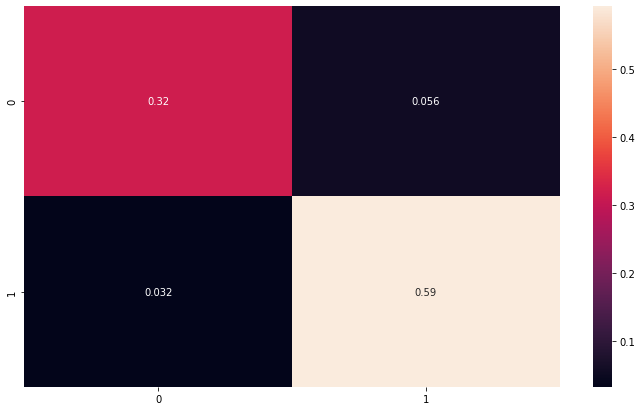

In [ ]:
#confusion
# constant for classes
classes = ('0', '1')
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/len(y_true), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))f
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')
cf_matrix

In [ ]:
print(f'Accuracy: no pneumonia: {199/(234)}%, pneumonia: {370/390}%')

Accuracy: no pneumonia: 0.8504273504273504%, pneumonia: 0.9487179487179487%


In [ ]:
#precission
p_s = precision_score(y_true, y_pred, average='weighted')
#recall
r_s = recall_score(y_true, y_pred, average='weighted')
#f1 score
f1_s = f1_score(y_true, y_pred, average='weighted')

In [ ]:
print(f'Precision score: {p_s}\nRecall score: {r_s}\nf1 score: {f1_s}')

Precision score: 0.911741078978522
Recall score: 0.9118589743589743
f1 score: 0.911231204964805


#Single samples prediction

In [ ]:
def predict(model, image):
    with torch.no_grad():
        net_out = model(image)  # returns a list,
        predicted_class = torch.argmax(net_out)
        print('net_out: ', net_out)
    return predicted_class.item()

In [ ]:
import skimage
from skimage import io
from skimage.transform import resize

pneumonia_2 = skimage.io.imread('/content/drive/MyDrive/Colab Notebooks/Med_MNIST_inż/pneumonia_samples/pneumonia_2.jpeg')
pneumonia_2_resized = resize(pneumonia_2, (28, 28))

pneumonia_1 = skimage.io.imread('/content/drive/MyDrive/Colab Notebooks/Med_MNIST_inż/pneumonia_samples/pneumonia_1.jpeg')
pneumonia_1_resized = resize(pneumonia_1, (28, 28))

no_pneumonia_10 = skimage.io.imread('/content/drive/MyDrive/Colab Notebooks/Med_MNIST_inż/pneumonia_samples/no_pneumonia_10.jpeg')
no_pneumonia_10_resized = resize(no_pneumonia_10, (28, 28))

no_pneumonia_11 = skimage.io.imread('/content/drive/MyDrive/Colab Notebooks/Med_MNIST_inż/pneumonia_samples/no_pneumonia_11.jpeg')
no_pneumonia_11_resized = resize(no_pneumonia_11, (28, 28))

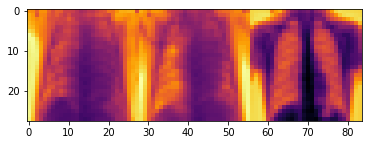

In [ ]:
plt.imshow(np.hstack((pneumonia_1_resized,pneumonia_2_resized, no_pneumonia_5_resized)), cmap="inferno_r")

In [ ]:
images_no_pneumonia = []
for (data,label) in test_dataset:
  if label == 0:
    images_no_pneumonia.append(data)

images_pneumonia = []
for (data,label) in test_dataset:
  if label == 1:
    images_pneumonia.append(data)

In [ ]:
img_0 = images_no_pneumonia[4].reshape(1,1, 28,-1)
predicted =  predict(model_pneumonia, torch.Tensor(img_0))
predicted

net_out:  tensor([[9.9952e-01, 4.7929e-04]])


0

In [ ]:
img_1 = images_no_pneumonia[0].reshape(1,1, 28,-1)
predicted =  predict(model_pneumonia, torch.Tensor(img_1 ))
predicted

net_out:  tensor([[0.0025, 0.9975]])


1

In [ ]:
np.save("/content/drive/MyDrive/Colab Notebooks/Med_MNIST_inż/img_pneumonia_0_p.npy",
        img_0 )
np.save("/content/drive/MyDrive/Colab Notebooks/Med_MNIST_inż/img_pneumonia_1_p.npy",
        img_1 )

In [ ]:
image = np.load("/content/drive/MyDrive/Colab Notebooks/Med_MNIST_inż/img_1.npy")

In [ ]:
pred = predict(model_pneumonia, torch.Tensor(image))
pred

net_out:  tensor([[0.9921, 0.0079]])


0